# **Import All NecessaryPackages**

In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.resnet_v2 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import load_model
import os
import cv2
import numpy as np
from keras.preprocessing import image
from PIL import Image
from tensorflow import lite
#from tensorflow.keras.models import load_model

2024-02-24 17:36:16.986933: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 17:36:16.987091: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 17:36:17.133251: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Preprocessing the Data**

In [2]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]


train_path = '/kaggle/input/pakistan-currency-dataset/Pakistan/Training'
valid_path = '/kaggle/input/pakistan-currency-dataset/Pakistan/Valid'

# add preprocessing layer to the front of ResNet50V2
resnet = ResNet50V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in resnet.layers:
  layer.trainable = False

# useful for getting number of classes
folders = glob('/kaggle/input/pakistan-currency-dataset/Pakistan/Training/*')
print(folders)

# our layers - you can add more if you want
x = Flatten()(resnet.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


#ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory('/kaggle/input/pakistan-currency-dataset/Pakistan/Training',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/kaggle/input/pakistan-currency-dataset/Pakistan/Valid',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

94668760/94668760 [==============================] - 4s 0us/step
['/kaggle/input/pakistan-currency-dataset/Pakistan/Training/10Rs', '/kaggle/input/pakistan-currency-dataset/Pakistan/Training/1000Rsback', '/kaggle/input/pakistan-currency-dataset/Pakistan/Training/50Rs', '/kaggle/input/pakistan-currency-dataset/Pakistan/Training/5000Rs', '/kaggle/input/pakistan-currency-dataset/Pakistan/Training/10Rsback', '/kaggle/input/pakistan-currency-dataset/Pakistan/Training/500Rsback', '/kaggle/input/pakistan-currency-dataset/Pakistan/Training/20Rs', '/kaggle/input/pakistan-currency-dataset/Pakistan/Training/100Rs', '/kaggle/input/pakistan-currency-dataset/Pakistan/Training/5000Rsback', '/kaggle/input/pakistan-currency-dataset/Pakistan/Training/1000Rs', '/kaggle/input/pakistan-currency-dataset/Pakistan/Training/50Rsback', '/kaggle/input/pakistan-currency-dataset/Pakistan/Training/500Rs', '/kaggle/input/pakistan-currency-dataset/Pakistan/Training/100Rsback', '/kaggle/input/pakistan-currency-dataset

# **Run epochs**

In [3]:
# fit the model
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/tmp/ipykernel_18/2033252562.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/10
186/186 [==============================] - 603s 3s/step - loss: 8.0643 - accuracy: 0.4367 - val_loss: 4.5445 - val_accuracy: 0.6483
Epoch 2/10
186/186 [==============================] - 611s 3s/step - loss: 4.3818 - accuracy: 0.6895 - val_loss: 5.3663 - val_accuracy: 0.7415
Epoch 3/10
186/186 [==============================] - 609s 3s/step - loss: 3.2156 - accuracy: 0.7667 - val_loss: 7.3395 - val_accuracy: 0.6653
Epoch 4/10
186/186 [==============================] - 590s 3s/step - loss: 2.7198 - accuracy: 0.8094 - val_loss: 7.4591 - val_accuracy: 0.7203
Epoch 5/10
186/186 [==============================] - 607s 3s/step - loss: 2.6004 - accuracy: 0.8351 - val_loss: 7.7626 - val_accuracy: 0.7331
Epoch 6/10
186/186 [==============================] - 609s 3s/step - loss: 2.2273 - accuracy: 0.8591 - val_loss: 6.5304 - val_accuracy: 0.7669
Epoch 7/10
186/186 [==============================] - 590s 3s/step - loss: 2.0048 - accuracy: 0.8665 - val_loss: 7.4723 - val_accuracy: 0.7585

# **Loss Graph**

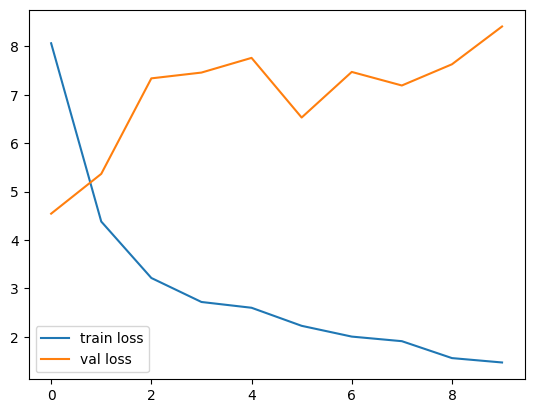

In [4]:
## loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
#plt.savefig('LossVal_loss')

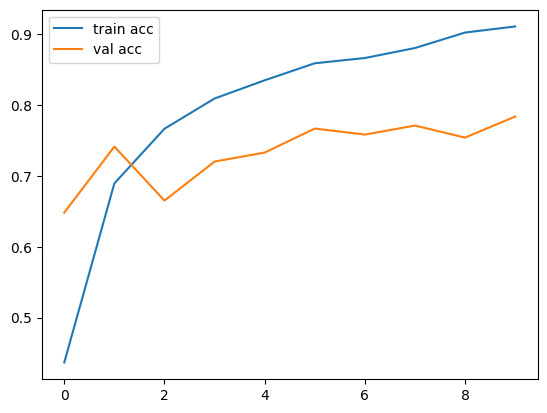

In [5]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')  # Corrected key
plt.legend()
plt.show()
#plt.savefig('AccVal_acc')

# **Saved Model**

In [6]:
# model.save('/content/gdrive/MyDrive/Models/VGG16/VGG16_AC_69/VGG16.h5')
#model_save_path = '/kaggle/working/ResNet50V2.h5'
model_save_path = '/kaggle/working/ResNet50V2.keras'
model.save(model_save_path)
print('Your Model is==> ',os.getcwd())
# Confirm the save path
print(f"Model saved successfully at: {model_save_path}")

Your Model is==>  /kaggle/working
Model saved successfully at: /kaggle/working/ResNet50V2.keras


# **Testing The Model**

['1000Rs', '1000Rsback', '100Rs', '100Rsback', '10Rs', '10Rsback', '20Rs', '20Rsback', '5000Rs', '5000Rsback', '500Rs', '500Rsback', '50Rs', '50Rsback', 'others']
1/1 [==============================] - 1s 1s/step


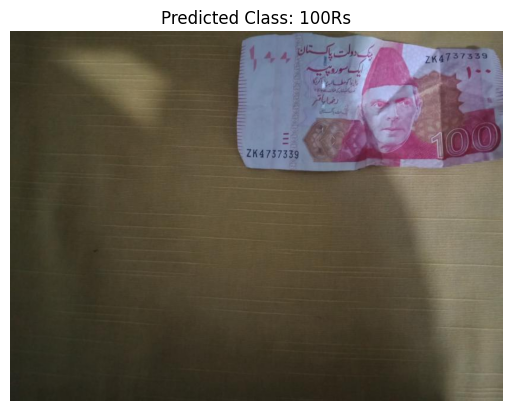

In [7]:
# Load the trained model
model_path = model_save_path
# Update with the actual path to your saved model
loaded_model = load_model(model_path)


# Get the class names
class_names = sorted(training_set.class_indices.keys())
print(class_names)


# Specify the path to the test image
test_img_path = '/kaggle/input/pakistanicurrencydataset/data-rescaled/100_front/IMG20211228215442.jpg'

# Function to preprocess an image
def preprocess_img(img_path):
    img = Image.open(img_path)  # Use PIL to open the image
    img = img.resize((224, 224))  # Resize the image
    img_array = np.array(img)  # Convert PIL image to NumPy array
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

# Function to predict the class of an image
def predict_class(img_path):
    img = preprocess_img(img_path)
    prediction = loaded_model.predict(img)
    predicted_class = class_names[np.argmax(prediction)]
    return predicted_class

# Predict the class for the test image
predicted_class = predict_class(test_img_path)

# Display the test image and predicted class
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

plt.imshow(test_img)
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()
